# Modelling alternatives to the Test-Intensity model
Since only the flow from E_2 to R_n should matter for the ratio R_p/(R_p+R_n), some alternative formulations should be possible

In this notebook, some alternatives are compared

In [2]:
%matplotlib widget

import sys
sys.path.append("./../scripts")
import PandemiXFunctions as pf
import PandemiXModelFunctions as pmf

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['figure.facecolor'] = (1,1,1,1)
plt.rcParams["image.cmap"] = "tab10"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
fs_label = 16
parameters = {
                'axes.labelsize': fs_label,
                'axes.titlesize': fs_label+4,
                'xtick.labelsize': fs_label,
                'ytick.labelsize': fs_label, 
                'legend.fontsize': fs_label, 
                'lines.markersize': 10,
                'lines.linewidth': 3
             }
plt.rcParams.update(parameters)

import datetime
             
from scipy.integrate import cumtrapz
# int_I = cumtrapz(np.exp(u_H*ts)*Is,ts, initial=0)
# Hs = np.exp(-u_H*ts) * (r_chr*pars_full['gamma']*int_I + k) 

In [3]:
# Model with explicit symptomatic category and keeping track of whether recovered were found or not
modelMeta = ({
     'beta * S * (P+A)' : ['S','E1'],
     'gamma * E1' : ['E1','E2'],
     'gamma * E2' : ['E2','P'],
     'gamma * rho * P' : ['P','I'],
     'gamma * (1-rho) * P' : ['P','A'],
     'nu * A' : ['A',None],
     'nu * Q' : ['Q','Rp'],
     'nu * I' : ['I','Rp'], # Assuming that symptomatic cases get tested, but aren't included in Q 
     'tau * E2' : ['E2','Q'],
     'tau * P'  : ['P','Q'],
     'tau * A'  : ['A','Q'],     
},
['S','E1','E2','P','A','Q','I','Rp'],['beta','gamma','nu','rho','tau'])


# Alternative 1: Extra I-step

In [4]:
# Model with explicit symptomatic category and keeping track of whether recovered were found or not
modelMeta_ExtraI = ({
     'beta * S * (P+A)' : ['S','E1'],
     'gamma * E1' : ['E1','E2'],
     'gamma * E2' : ['E2','P'],
     'gamma * rho * P' : ['P','I'],
     'gamma * (1-rho) * P' : ['P','A'],
     'nu * A' : ['A',None],
     'nu * Q' : ['Q','Rp'],
    #  'nu * I' : ['I','Rp'], # Assuming that symptomatic cases get tested, but aren't included in Q 
     'nu * I' : ['I','I2'], 
     'nu * I2' : ['I2','Rp'], 
     'tau * E2' : ['E2','Q'],
     'tau * P'  : ['P','Q'],
     'tau * A'  : ['A','Q'],     
},
['S','E1','E2','P','A','Q','I','I2','Rp'],['beta','gamma','nu','rho','tau'])


In [12]:
# Initialize everything
iniExp = 100/5800000

# E1_0 = iniExp 
# E2_0 = 0
# P_0 = 0
E1_0 = iniExp
E2_0 = 0
P_0 = 0  
A_0 = 0 
I_0 = 0 
S_0 = 1 - E1_0 -E2_0 - P_0 - A_0-I_0

init = {'S' : S_0,'E1':E1_0,'E2':E2_0 , 'P':P_0,'A':A_0,'Q':0,'I':I_0,'Rp':0}
init_2 = {'S' : S_0,'E1':E1_0,'E2':E2_0 , 'P':P_0,'A':A_0,'Q':0,'I':I_0,'Rp':0,'I2':0}

gamma = 1/3
nu = 1/3
rho = 0.5
beta = 3*gamma
tau = 0.2
pars = {'beta':beta,'nu':nu,'gamma':gamma,'rho':rho,'tau':tau}


tEnd = 300
sch1 = pmf.Scheme(modelMeta,init,pars,0,tEnd,Changes=[])
sch1_2 = pmf.Scheme(modelMeta_ExtraI,init,pars,0,tEnd,Changes=[])


sch1.simulate(tRes=1000)
sch1_2.simulate(tRes=1000)

Rn1 = 1-sch1.result.y.sum(axis=0)
Rn1_2 = 1-sch1_2.result.y.sum(axis=0)

C:\Users\rakrpe\AppData\Local\Temp\ipykernel_59296\16378596.py:3: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(sch1.result.t,sch1.result.Rp/(sch1.result.Rp+Rn1))
C:\Users\rakrpe\AppData\Local\Temp\ipykernel_59296\16378596.py:4: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(sch1_2.result.t,sch1_2.result.Rp/(sch1_2.result.Rp+Rn1_2))


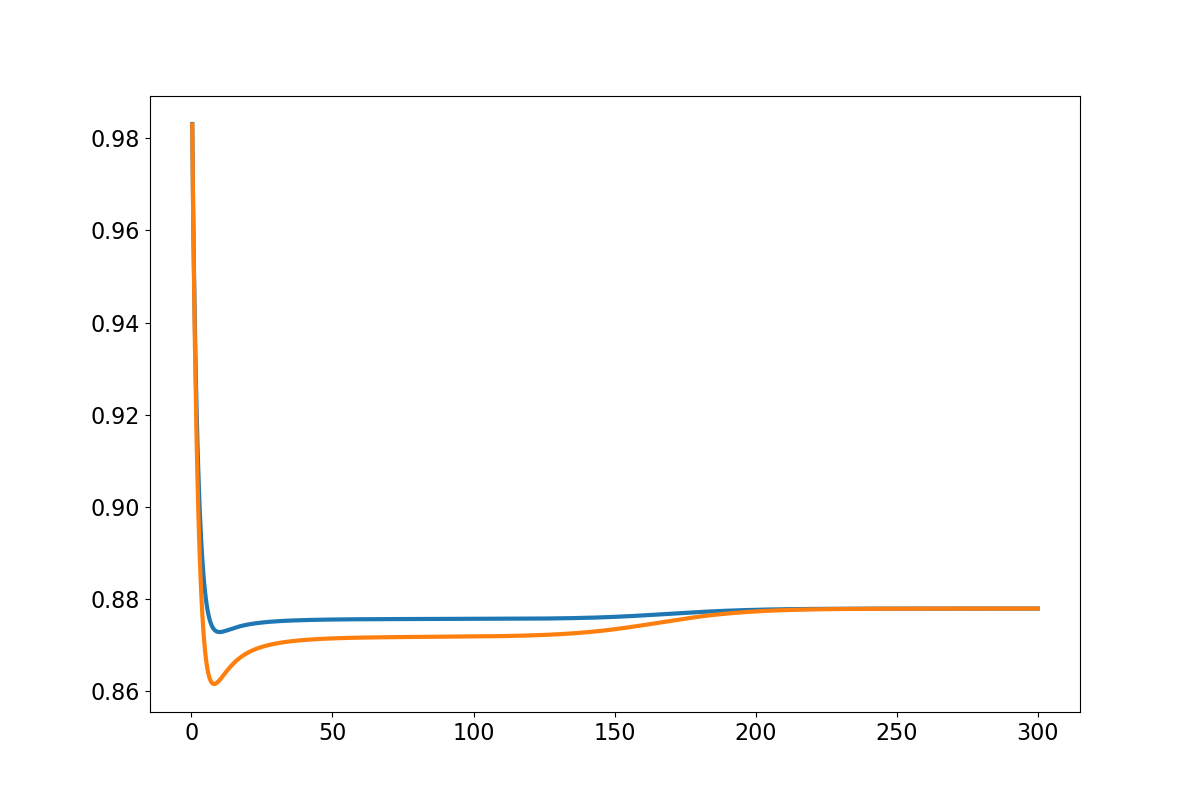

In [21]:
fig,ax = plt.subplots()

ax.plot(sch1.result.t,sch1.result.Rp/(sch1.result.Rp+Rn1))
ax.plot(sch1_2.result.t,sch1_2.result.Rp/(sch1_2.result.Rp+Rn1_2))
# ax.plot(sch1.result.t,sch1.result.A)
# ax.plot(sch1_2.result.t,sch1_2.result.A)

# Alternative 2: Infection-pressure from I

In [39]:
# Model with explicit symptomatic category and keeping track of whether recovered were found or not
modelMeta_infI = ({
     # 'beta * S * (P+A)' : ['S','E1'],
     'beta * S * (P+A+I)' : ['S','E1'],
     'gamma * E1' : ['E1','E2'],
     'gamma * E2' : ['E2','P'],
     'gamma * rho * P' : ['P','I'],
     'gamma * (1-rho) * P' : ['P','A'],
     'nu * A' : ['A',None],
     'nu * Q' : ['Q','Rp'],
     'nu * I' : ['I','Rp'], # Assuming that symptomatic cases get tested, but aren't included in Q 
     'tau * E2' : ['E2','Q'],
     'tau * P'  : ['P','Q'],
     'tau * A'  : ['A','Q'],     
},
['S','E1','E2','P','A','Q','I','Rp'],['beta','gamma','nu','rho','tau'])


In [59]:
# Initialize everything
iniExp = 100/5800000

# E1_0 = iniExp 
# E2_0 = 0
# P_0 = 0
E1_0 = iniExp
E2_0 = 0
P_0 = 0  
A_0 = 0 
I_0 = 0 
S_0 = 1 - E1_0 -E2_0 - P_0 - A_0-I_0

init = {'S' : S_0,'E1':E1_0,'E2':E2_0 , 'P':P_0,'A':A_0,'Q':0,'I':I_0,'Rp':0}

gamma = 1/3
nu = 1/3
rho = 0.5
rho = 0.3
beta = 3*gamma
tau = 0.2
pars = {'beta':beta,'nu':nu,'gamma':gamma,'rho':rho,'tau':tau}


tEnd = 300
sch2 = pmf.Scheme(modelMeta,init,pars,0,tEnd,Changes=[])
sch2_2 = pmf.Scheme(modelMeta_infI,init,pars,0,tEnd,Changes=[])


sch2.simulate(tRes=1000)
sch2_2.simulate(tRes=1000)

Rn2 = 1-sch2.result.y.sum(axis=0)
Rn2_2 = 1-sch2_2.result.y.sum(axis=0)

In [62]:
R_E2 = gamma/(gamma+tau)
R_P = (gamma*(1-rho))/(gamma+tau)
R_A = nu/(nu+tau)

ratioFound = 1-(R_P*R_A*R_E2)

C:\Users\rakrpe\AppData\Local\Temp\ipykernel_59296\597720800.py:4: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(sch2.result.t,sch2.result.Rp/(sch2.result.Rp+Rn2))
C:\Users\rakrpe\AppData\Local\Temp\ipykernel_59296\597720800.py:5: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(sch2_2.result.t,sch2_2.result.Rp/(sch2_2.result.Rp+Rn2_2))


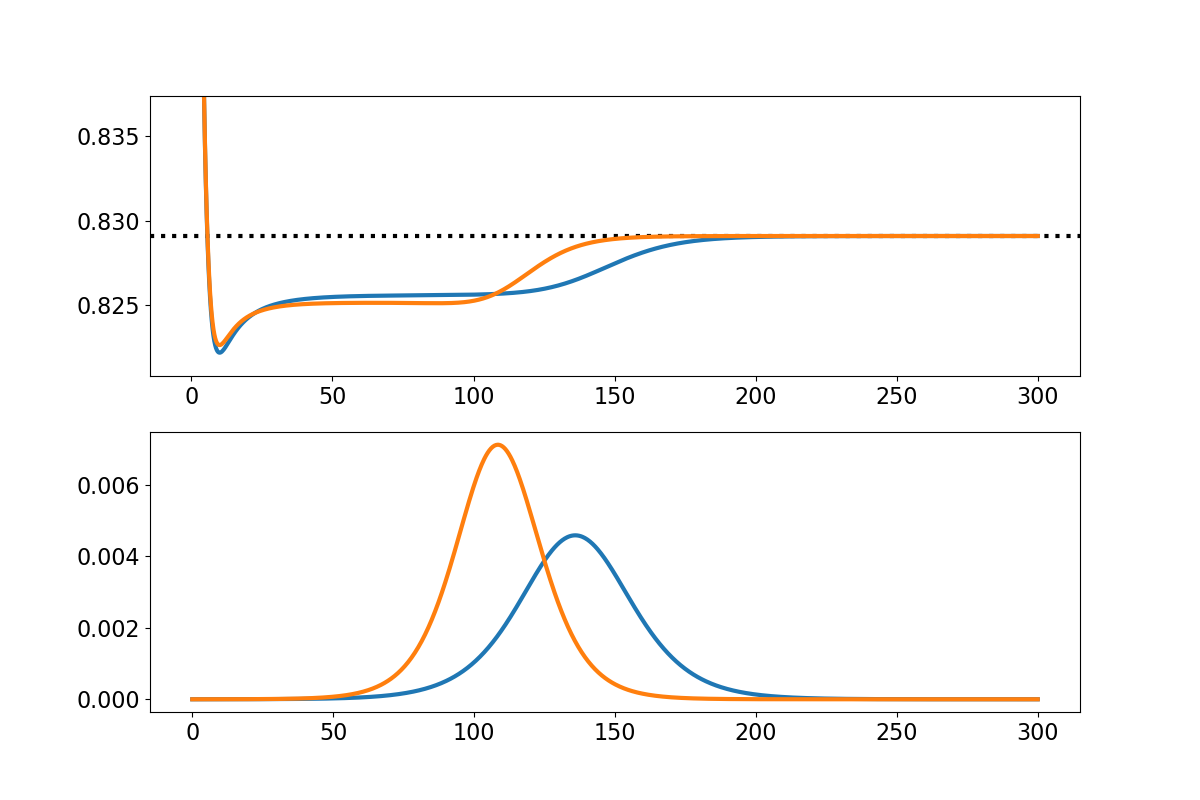

In [63]:
fig,(ax,ax2) = plt.subplots(2,1)

ax.axhline(ratioFound,color='k',linestyle=':')
ax.plot(sch2.result.t,sch2.result.Rp/(sch2.result.Rp+Rn2))
ax.plot(sch2_2.result.t,sch2_2.result.Rp/(sch2_2.result.Rp+Rn2_2))
ax.set_ylim([ratioFound*0.99,ratioFound*1.01])
ax2.plot(sch2.result.t,sch2.result.I)
ax2.plot(sch2_2.result.t,sch2_2.result.I)

# Alternative 3: Non-testing of (fraction of) I

Correspond to not 100% of symptomatic cases being tested

This model is not equivalent, but same type of calculation should work

In [53]:
modelMeta_NonPerfectSymp = ({
     'beta * S * (P+A)' : ['S','E1'],
     'gamma * E1' : ['E1','E2'],
     'gamma * E2' : ['E2','P'],
     'gamma * rho * P' : ['P','I'],
     'gamma * (1-rho) * P' : ['P','A'],
     'nu * A' : ['A',None],
     'nu * Q' : ['Q','Rp'],
    #  'nu * I' : ['I','Rp'], # Assuming that symptomatic cases get tested, but aren't included in Q 
     'nu * kappa * I' : ['I','Rp'],
     'nu * (1 - kappa) * I' : ['I','Rn'],
     'tau * E2' : ['E2','Q'],
     'tau * P'  : ['P','Q'],
     'tau * A'  : ['A','Q'],     
},
['S','E1','E2','P','A','Q','I','Rp'],['beta','gamma','nu','rho','tau','kappa'])


In [67]:
# Initialize everything
iniExp = 100/5800000

# E1_0 = iniExp 
# E2_0 = 0
# P_0 = 0
E1_0 = iniExp
E2_0 = 0
P_0 = 0  
A_0 = 0 
I_0 = 0 
S_0 = 1 - E1_0 -E2_0 - P_0 - A_0-I_0

init = {'S' : S_0,'E1':E1_0,'E2':E2_0 , 'P':P_0,'A':A_0,'Q':0,'I':I_0,'Rp':0}

gamma = 1/3
nu = 1/3
rho = 0.5
beta = 3*gamma
tau = 0.2
# pars = {'beta':beta,'nu':nu,'gamma':gamma,'rho':rho,'tau':tau}
kappa = 0.75
pars = {'beta':beta,'nu':nu,'gamma':gamma,'rho':rho,'tau':tau,'kappa':kappa}


tEnd = 300
sch3 = pmf.Scheme(modelMeta_NonPerfectSymp,init,pars,0,tEnd,Changes=[])


sch3.simulate(tRes=1000)

Rn3 = 1-sch3.result.y.sum(axis=0)

In [72]:
R_E2 = gamma/(gamma+tau)
# R_Pk = (gamma*)
# frac_PtoRn = (1-rho)*gamma*nu + rho*gamma*(1-kappa)
# frac_Pall = tau+gamma 
# R_Pkappa = frac_PtoRn/frac_Pall

frac_PtoI = (rho*gamma)/(gamma+tau)
frac_PtoA = ((1-rho)*gamma)/(gamma+tau)
frac_ItoRn = (1-kappa)
frac_AtoRn = nu/(nu+tau)

R_Pkappa = frac_PtoI*frac_ItoRn + frac_PtoA*frac_AtoRn

ratioFound_kappa = 1-R_E2*R_Pkappa
ratioFound_kappa

# R_P = (gamma*(1-rho))/(gamma+tau)
# R_A = nu/(nu+tau)

# ratioFound = 1-(R_P*R_A*R_E2)

0.8291015625

C:\Users\rakrpe\AppData\Local\Temp\ipykernel_59296\232438975.py:4: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(sch3.result.t,sch3.result.Rp/(sch3.result.Rp+Rn3))


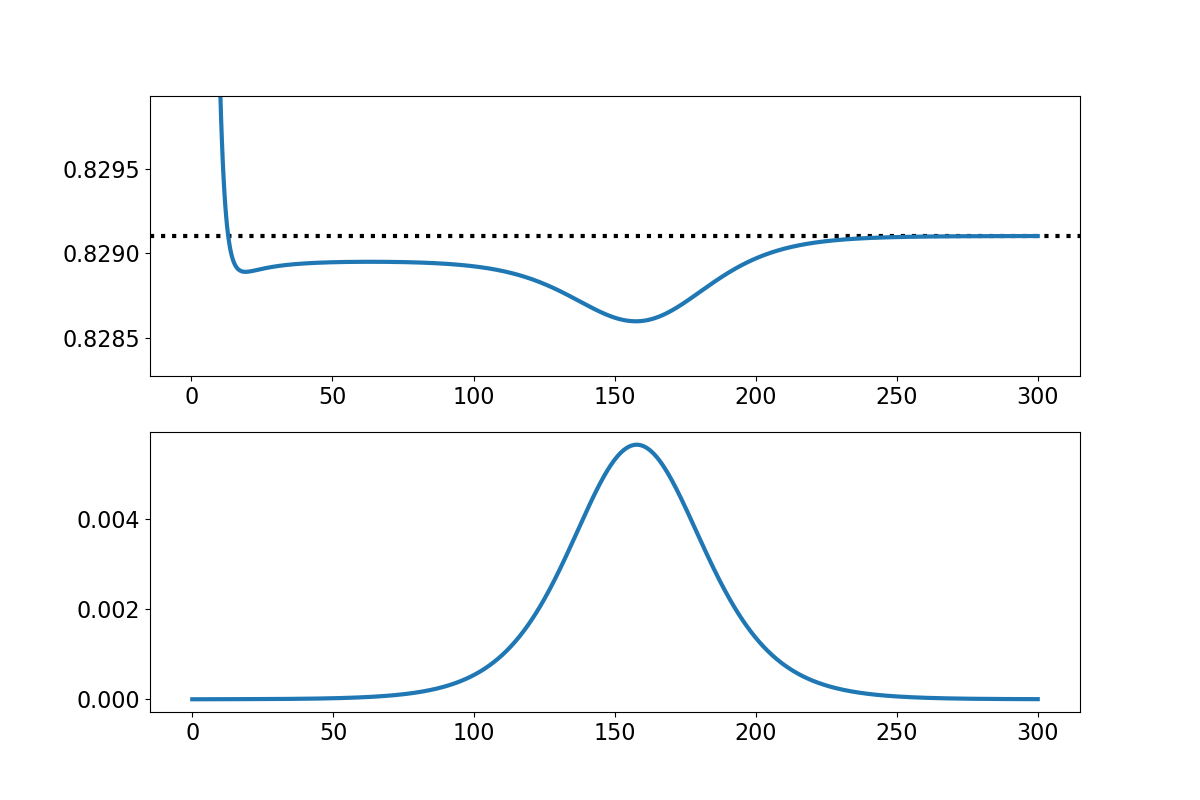

In [75]:
fig,(ax,ax2) = plt.subplots(2,1)

ax.axhline(ratioFound_kappa,color='k',linestyle=':')
ax.plot(sch3.result.t,sch3.result.Rp/(sch3.result.Rp+Rn3))
ax.set_ylim([ratioFound_kappa*0.999,ratioFound_kappa*1.001])
ax2.plot(sch3.result.t,sch3.result.I)